The following is a simple demonstration of the MuJoCo physics engine, designed to demonstrate the multibody simulation capabilities of the package. 

We will use a double pendulum setup to demonstrate the gravity, damping, and control features of the package. 

First, we will import all the packages needed. We will import the physics engine, its viewer, as well as some data visualization packages. 

In [1]:
import mujoco
import mujoco.viewer
import numpy as np
import matplotlib.pyplot as plt
import time

Next, we will define our physical model, via an XML string. Note the gravity, hinge definitions, and actuator definitions. 

In [2]:
model_xml = """
<mujoco>
<option gravity="0 0 -9.81" timestep="0.001"/>
<worldbody>
<body name="link1" pos="0 0 0">
<joint name="hinge1" type="hinge" axis="0 1 0" damping="0.001"/>
<geom type="capsule" fromto="0 0 0 0 0 -0.5" size="0.03" rgba="0.2 0.5 0.9 1"/>
<body name="link2" pos="0 0 -0.5">
<joint name="hinge2" type="hinge" axis="0 1 0" damping="0.001"/>
<geom type="capsule" fromto="0 0 0 0 0 -0.5" size="0.05" rgba="0.9 0.3 0.3 1"/>
</body>
</body>
</worldbody>
<actuator>
<motor joint="hinge1" ctrllimited="true" ctrlrange="-1 1"/>
<motor joint="hinge2" ctrllimited="true" ctrlrange="-1 1"/>
</actuator>
</mujoco>
"""

model = mujoco.MjModel.from_xml_string(model_xml)
data = mujoco.MjData(model)

Lets run the pendulum under gravity. As a double pendulum, we can observe some natural chaos. While this seems pretty simple, the C engine is computing the accelerations, constraint forces, and gravity in the background. 

In [3]:
data.qpos[:] = [np.pi / 2, np.pi / 2] # [upper, lower] link angle in radians


We will also log states (collect data at every timestep)

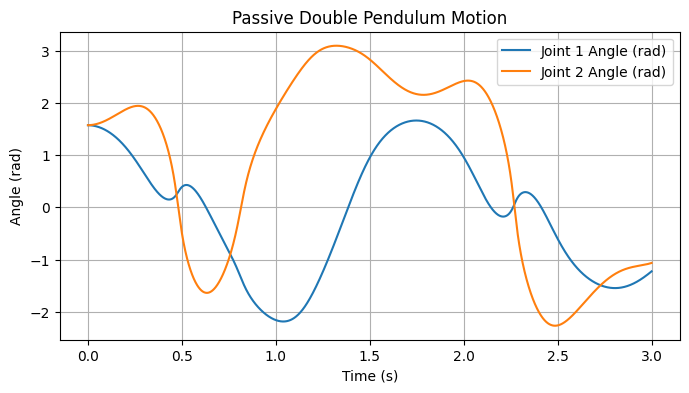

In [4]:
q_log = []
t_log = []


for i in range(3000): # 3 seconds at 1 kHz
    mujoco.mj_step(model, data)
    q_log.append(data.qpos.copy())
    t_log.append(i * model.opt.timestep)


q_log = np.array(q_log)
t_log = np.array(t_log)


plt.figure(figsize=(8,4))
plt.plot(t_log, q_log[:,0], label='Joint 1 Angle (rad)')
plt.plot(t_log, q_log[:,1], label='Joint 2 Angle (rad)')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Passive Double Pendulum Motion')
plt.legend()
plt.grid()
plt.show()

This is all pretty simple so far. Let's now adjust some parameters, to see the impact on the motion of the pendulum. We can add some damping to simulate energy loss, and also show off MuJoCo's actuation with some applied torques. 

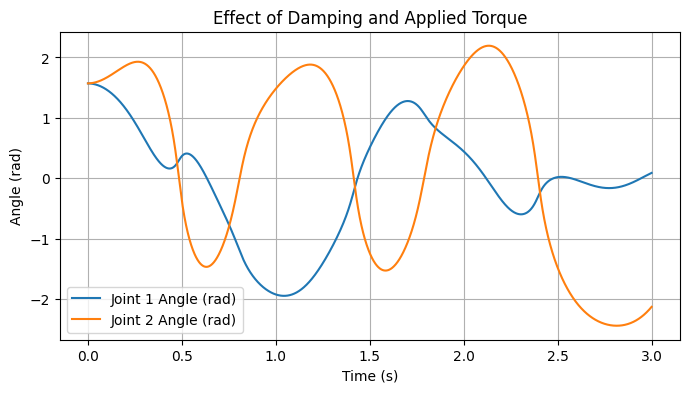

In [5]:
model.dof_damping[:] = 0.1 # increase damping
data.qpos[:] = [np.pi/2, np.pi/2]
data.qvel[:] = 0


q_log2, t_log2 = [], []
for i in range(3000):
    torque = 0.5 if 1000 < i < 1500 else 0.0 # pulse torque
    data.ctrl[:] = [torque, 0]
    mujoco.mj_step(model, data)
    q_log2.append(data.qpos.copy())
    t_log2.append(i * model.opt.timestep)


q_log2, t_log2 = np.array(q_log2), np.array(t_log2)


plt.figure(figsize=(8,4))
plt.plot(t_log2, q_log2[:,0], label='Joint 1 Angle (rad)')
plt.plot(t_log2, q_log2[:,1], label='Joint 2 Angle (rad)')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Effect of Damping and Applied Torque')
plt.legend()
plt.grid()
plt.show()

We've all seen the iconic controls video of stabilizing a pendulum upright. Let's try that (feedback control loop) in our simulation!

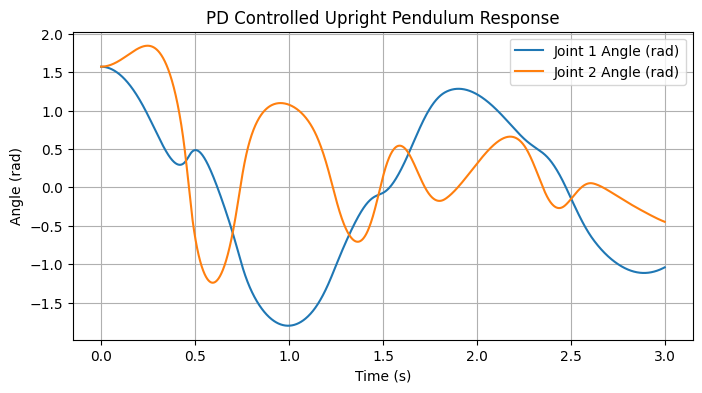

In [6]:
def pd_control(q, qdot, q_ref, kp, kd):
    return kp * (q_ref - q) - kd * qdot


q_ref = np.array([0.0, 0.0])


data.qpos[:] = [np.pi/2, np.pi/2]
data.qvel[:] = 0


q_log3, t_log3 = [], []


for i in range(3000):
    q = data.qpos.copy()
    qdot = data.qvel.copy()
    ctrl = pd_control(q, qdot, q_ref, kp=20, kd=2)
    data.ctrl[:] = ctrl
    mujoco.mj_step(model, data)
    q_log3.append(q)
    t_log3.append(i * model.opt.timestep)


q_log3, t_log3 = np.array(q_log3), np.array(t_log3)


plt.figure(figsize=(8,4))
plt.plot(t_log3, q_log3[:,0], label='Joint 1 Angle (rad)')
plt.plot(t_log3, q_log3[:,1], label='Joint 2 Angle (rad)')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('PD Controlled Upright Pendulum Response')
plt.legend()
plt.grid()
plt.show()

Okay, so we saw some numbers move around. Cool, but what about that real-time visualization in the slides? Let's launch the viewer!

In [ ]:

# with mujoco.viewer.launch_passive(model, data) as viewer:
    


#     print("Phase 1: Passive motion")
#     data.qpos[:] = [np.pi / 2, np.pi / 2]
#     data.qvel[:] = 0
#     model.dof_damping[:] = 0.001
#     mujoco.mj_forward(model, data)

#     start_sim = data.time
    
#     while viewer.is_running() and data.time - start_sim < 6.0:  # 10 simulated seconds
#         mujoco.mj_step(model, data)
#         viewer.sync()
#         #time.sleep(0.002)

#     print("Phase 2: Increased damping with torque pulse")
#     model.dof_damping[:] = 0.1
#     data.qpos[:] = [np.pi / 2, np.pi / 2]
#     data.qvel[:] = 0
#     mujoco.mj_forward(model, data)

#     start_sim = data.time
#     while viewer.is_running() and data.time - start_sim < 5.0:  # 5 simulated seconds
#         elapsed_sim = data.time - start_sim
#         # Apply a brief torque pulse between 2s–3s of simulated time
#         data.ctrl[:] = [0.5, 0.0] if 2.0 < elapsed_sim < 3.0 else [0.0, 0.0]
#         mujoco.mj_step(model, data)
#         viewer.sync()
#         #time.sleep(0.0001* speed)

#     print("Phase 3: PD control stabilization")
#     q_ref = np.array([0.0, 0.0])
#     data.qpos[:] = [np.pi / 2, np.pi / 2]
#     data.qvel[:] = 0
#     mujoco.mj_forward(model, data)

#     start_sim = data.time
#     while viewer.is_running() and data.time - start_sim < 6.0:  # 10 simulated seconds
#         q = data.qpos.copy()
#         qdot = data.qvel.copy()
#         data.ctrl[:] = pd_control(q, qdot, q_ref, kp=20, kd=2)
#         mujoco.mj_step(model, data)
#         viewer.sync()
#         #time.sleep(0.0001* speed)


Phase 1: Passive motion
Phase 2: Increased damping with torque pulse
Phase 3: PD control stabilization


In [ ]:
# with mujoco.viewer.launch_passive(model, data) as viewer:
    


#     print("Phase 1: Passive motion")
#     data.qpos[:] = [np.pi / 2, np.pi / 2]
#     data.qvel[:] = 0
#     model.dof_damping[:] = 0.001
#     mujoco.mj_forward(model, data)

#     start_sim = data.time
    
#     while viewer.is_running() and data.time - start_sim < 6.0:  # 10 simulated seconds
#         mujoco.mj_step(model, data)
#         viewer.sync()
#         # time.sleep(0.0000000000000002)


Phase 1: Passive motion


In [7]:
# Load model fresh for this phase
model = mujoco.MjModel.from_xml_string(model_xml)
data  = mujoco.MjData(model)

# Automatically match physics and render rates
physics_hz = int(1 / model.opt.timestep)   # e.g., 1000 Hz if timestep=0.001
render_hz  = 60                            # target ~60 FPS viewer update
steps_per_render = physics_hz // render_hz

print("Phase 1: Passive Motion – observe natural chaotic motion")

# Initial conditions
data.qpos[:] = [np.pi / 2, np.pi / 2]
data.qvel[:] = 0
model.dof_damping[:] = 0.001
mujoco.mj_forward(model, data)

# ---------- Real-time paced viewer loop ----------
target_duration = 25.0                     # seconds of real wall time
with mujoco.viewer.launch_passive(model, data) as viewer:
    wall_start = time.time()

    while viewer.is_running() and time.time() - wall_start < target_duration:
        frame_start = time.time()

        # advance physics several sub-steps
        for _ in range(steps_per_render):
            mujoco.mj_step(model, data)

        viewer.sync()

        # ----- real-time pacing -----
        # Each render frame represents (steps_per_render * timestep) seconds of simulated time.
        sim_dt = steps_per_render * model.opt.timestep
        elapsed = time.time() - frame_start
        # Sleep only if physics ran faster than real time
        if elapsed < sim_dt:
            time.sleep(sim_dt - elapsed)


Phase 1: Passive Motion – observe natural chaotic motion


In [8]:
# Load model fresh for this phase
model = mujoco.MjModel.from_xml_string(model_xml)
data  = mujoco.MjData(model)

# Match physics and render rates
physics_hz = int(1 / model.opt.timestep)   # e.g., 1000 Hz
render_hz  = 60                            # viewer refresh rate
steps_per_render = physics_hz // render_hz

print("Phase 2: Increased Damping with Torque Pulse – observe smoother motion and torque response")

# Initial conditions and parameters
model.dof_damping[:] = 0.1
data.qpos[:] = [np.pi / 2, np.pi / 2]
data.qvel[:] = 0
mujoco.mj_forward(model, data)

# ---------- Real-time paced viewer loop ----------
target_duration = 25.0                     # seconds of real wall time
with mujoco.viewer.launch_passive(model, data) as viewer:
    wall_start = time.time()

    while viewer.is_running() and time.time() - wall_start < target_duration:
        frame_start = time.time()

        # Compute elapsed real-time since start for torque timing
        elapsed_wall = time.time() - wall_start

        # Apply a brief torque pulse between 10–12 s of wall time
        if 10.0 < elapsed_wall < 12.0:
            data.ctrl[:] = [0.5, 0.0]
        else:
            data.ctrl[:] = [0.0, 0.0]

        # Advance physics several sub-steps
        for _ in range(steps_per_render):
            mujoco.mj_step(model, data)

        viewer.sync()

        # ----- real-time pacing -----
        sim_dt = steps_per_render * model.opt.timestep
        elapsed = time.time() - frame_start
        if elapsed < sim_dt:
            time.sleep(sim_dt - elapsed)


Phase 2: Increased Damping with Torque Pulse – observe smoother motion and torque response


In [9]:
# Load model fresh for this phase
model = mujoco.MjModel.from_xml_string(model_xml)
data  = mujoco.MjData(model)

# Physics / render configuration
physics_hz = int(1 / model.opt.timestep)   # typically 1000 Hz
render_hz  = 60                            # viewer update rate
steps_per_render = physics_hz // render_hz

def pd_control(q, qdot, q_ref, kp, kd):
    """Simple proportional–derivative joint torque control."""
    return kp * (q_ref - q) - kd * qdot

print("Phase 3: PD Control Stabilization – observe the controller hold the links upright")

# Initial conditions
q_ref = np.array([0.0, 0.0])
data.qpos[:] = [np.pi / 2, np.pi / 2]      # start hanging downward
data.qvel[:] = 0
model.dof_damping[:] = 0.05
mujoco.mj_forward(model, data)

# ---------- Real-time paced viewer loop ----------
target_duration = 25.0                     # seconds of real wall time
with mujoco.viewer.launch_passive(model, data) as viewer:
    wall_start = time.time()

    while viewer.is_running() and time.time() - wall_start < target_duration:
        frame_start = time.time()

        # Compute PD control torques
        q     = data.qpos.copy()
        qdot  = data.qvel.copy()
        ctrl  = pd_control(q, qdot, q_ref, kp=20, kd=2)
        data.ctrl[:] = ctrl

        # Advance physics several sub-steps per rendered frame
        for _ in range(steps_per_render):
            mujoco.mj_step(model, data)

        viewer.sync()

        # ----- real-time pacing -----
        sim_dt = steps_per_render * model.opt.timestep
        elapsed = time.time() - frame_start
        if elapsed < sim_dt:
            time.sleep(sim_dt - elapsed)


Phase 3: PD Control Stabilization – observe the controller hold the links upright
